We’ll create a small synthetic dataset with correlated features to make it easy to follow.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Let's create some synthetic data
n_samples = 100
x1 = np.random.normal(0, 1, n_samples)
x2 = 2 * x1 + np.random.normal(0, 0.2, n_samples)  # Strongly correlated with x1
x3 = np.random.normal(0, 1, n_samples)             # Uncorrelated with x1 and x2

df = pd.DataFrame({
    'Feature 1': x1,
    'Feature 2': x2,
    'Feature 3': x3
})

df.head()



,Feature 1,Feature 2,Feature 3
0,0.496714,0.710354,0.357787
1,-0.138264,-0.360658,0.560785
2,0.647689,1.226834,1.083051
3,1.523030,2.885604,1.053802
4,-0.234153,-0.500564,-1.377669


- Feature 1 and Feature 2 are highly correlated.
- Feature 3 is independent.

Before PCA, it's great to check how our features relate.

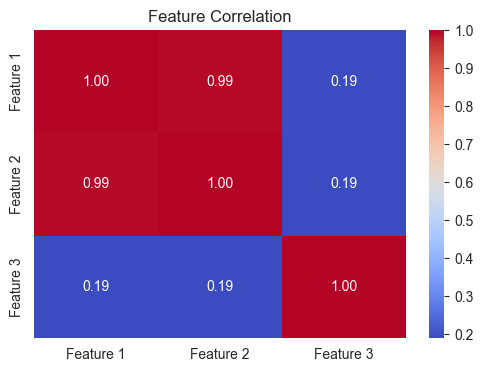

In [3]:
# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()



You’ll clearly see Feature 1 and Feature 2 are highly correlated → ideal for PCA!

PCA is affected by scale. Standardize features before applying PCA.

In [4]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Just in case:
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head()

,Feature 1,Feature 2,Feature 3
0,0.664619,0.510031,0.271485
1,-0.038089,-0.087887,0.459646
2,0.831697,0.798368,0.943743
3,1.800406,1.724416,0.916631
4,-0.144206,-0.165993,-1.337135


Let’s apply PCA and look at the explained variance.

- First component explains most variance (correlation between x1 and x2).
- Second and third explain less.


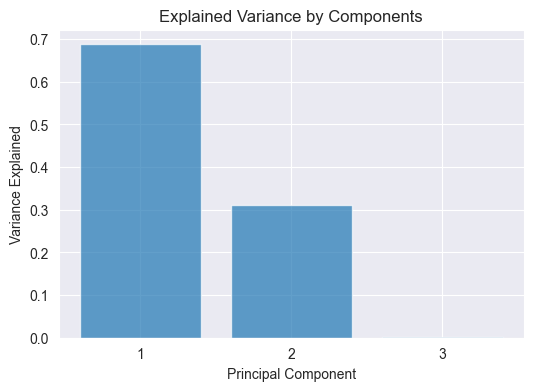

Cumulative explained variance:
[0.68742233 0.99815973 1.        ]


In [5]:
# Apply PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_

# Plot the variance explained by each principal component
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Components')
plt.xticks(range(1, len(explained_var)+1))
plt.show()

# Print cumulative explained variance
print("Cumulative explained variance:")
print(np.cumsum(explained_var))


Let’s project the original data into the PCA space.

In [6]:
# Transform the data
pca_data = pca.transform(scaled_data)

# Turn it into a DataFrame for better readability
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(len(df.columns))])
pca_df.head()

,PC1,PC2,PC3
0,0.871818,0.059956,0.109054
1,0.026220,0.467520,0.034455
2,1.348674,0.632727,0.022301
3,2.641028,0.278340,0.052801
4,-0.540158,-1.242659,0.017506


Let’s plot the first two principal components.

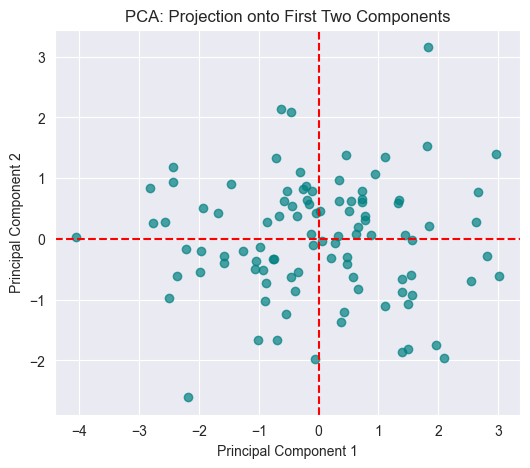

In [7]:
plt.figure(figsize=(6,5))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c='teal')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Projection onto First Two Components')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


We’ll check how much each original feature contributes to each principal component.

- Large absolute values indicate a strong contribution to that component.
- Signs (+/-) tell the direction of the relationship.


In [8]:
# PCA components (loadings)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(df.columns))],
                        index=df.columns)

print("Feature Loadings (contribution of original features to components):")
print(loadings)


Feature Loadings (contribution of original features to components):
                PC1       PC2       PC3
Feature 1  0.685699 -0.172050  0.707259
Feature 2  0.685440 -0.174327 -0.706953
Feature 3  0.244925  0.969541 -0.001606


Look at explained variance to decide how many components to keep.

Look at feature loadings to interpret what each component means.

If the first 2 components explain >90%, you could reduce dimensionality while keeping most information.

To better visualize and understand PCA:

Step 1: Plot the Original Data with Principal Components


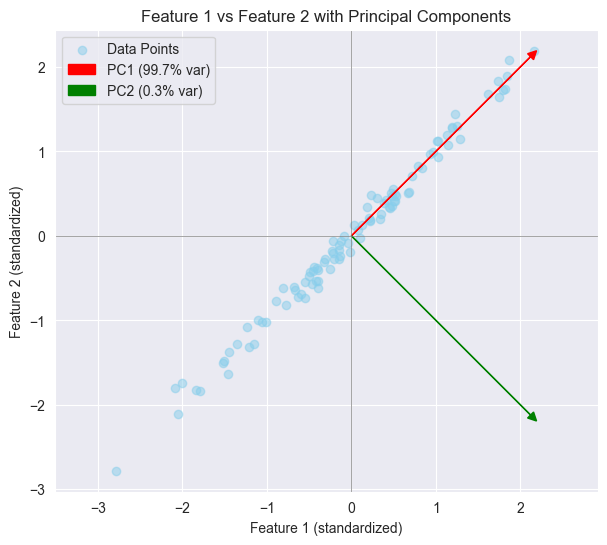

In [9]:
import matplotlib.pyplot as plt

# We'll focus on just Feature 1 and Feature 2
features = ['Feature 1', 'Feature 2']
X = scaled_df[features].values

# Fit PCA on just these two features to make a clean 2D plot
pca_2d = PCA(n_components=2)
pca_2d.fit(X)

# Get principal components and their directions
pcs = pca_2d.components_
mean = X.mean(axis=0)

# Plot the data
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color='skyblue', label='Data Points')
plt.xlabel('Feature 1 (standardized)')
plt.ylabel('Feature 2 (standardized)')
plt.title('Feature 1 vs Feature 2 with Principal Components')

# Draw PC1 and PC2 as arrows
for i, (comp, var) in enumerate(zip(pcs, pca_2d.explained_variance_ratio_)):
    plt.arrow(mean[0], mean[1], comp[0]*3, comp[1]*3, 
              head_width=0.1, head_length=0.1, color=['r', 'g'][i],
              label=f'PC{i+1} ({var*100:.1f}% var)')

plt.grid(True)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.legend()
plt.axis('equal')
plt.show()


Step 2: Look at Feature Loadings
Let’s interpret how each feature contributes to the principal components.

- PC1: High positive weights for Feature 1 and 2 → this component captures their combined effect.
- PC2: High negative loading for Feature 3 → this axis is mostly aligned with that feature.
- PC3: Mostly noise; small, mixed weights.


In [10]:
# Loadings matrix (feature contributions to each PC)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(df.columns))],
                        index=df.columns)

print("Feature Loadings:")
print(loadings.round(3))


Feature Loadings:
             PC1    PC2    PC3
Feature 1  0.686 -0.172  0.707
Feature 2  0.685 -0.174 -0.707
Feature 3  0.245  0.970 -0.002


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume X is your (n_samples x 200 features) dataset
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# PC1 loadings
pc1_loadings = pca.components_[0]  # First principal component

# Put into a DataFrame for better readability
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i+1}' for i in range(X.shape[1])]
loadings_df = pd.DataFrame({
    'Feature': feature_names,
    'PC1 Loading': pc1_loadings
})

# Sort by absolute loading value to see most influential features
top_features = loadings_df.reindex(loadings_df['PC1 Loading'].abs().sort_values(ascending=False).index)
top_features.head(10)  # Top 10 features contributing to PC1


,Feature,PC1 Loading
1,Feature 2,0.707107
0,Feature 1,0.707107


In [12]:
# All PCs: rows = PCs, columns = features
loadings_matrix = pd.DataFrame(pca.components_,
                               columns=feature_names,
                               index=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings_matrix.T.head()  # Transpose for easier viewing (features as rows)


,PC1,PC2
Feature 1,0.707107,0.707107
Feature 2,0.707107,-0.707107
